In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import PIL.Image
import PIL
import cv2
import os


In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
image_size = (128, 128)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:03<00:00, 74.11it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 69.32it/s]


In [6]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 128, 128, 3), (200, 128, 128, 3))

In [7]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [8]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [9]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

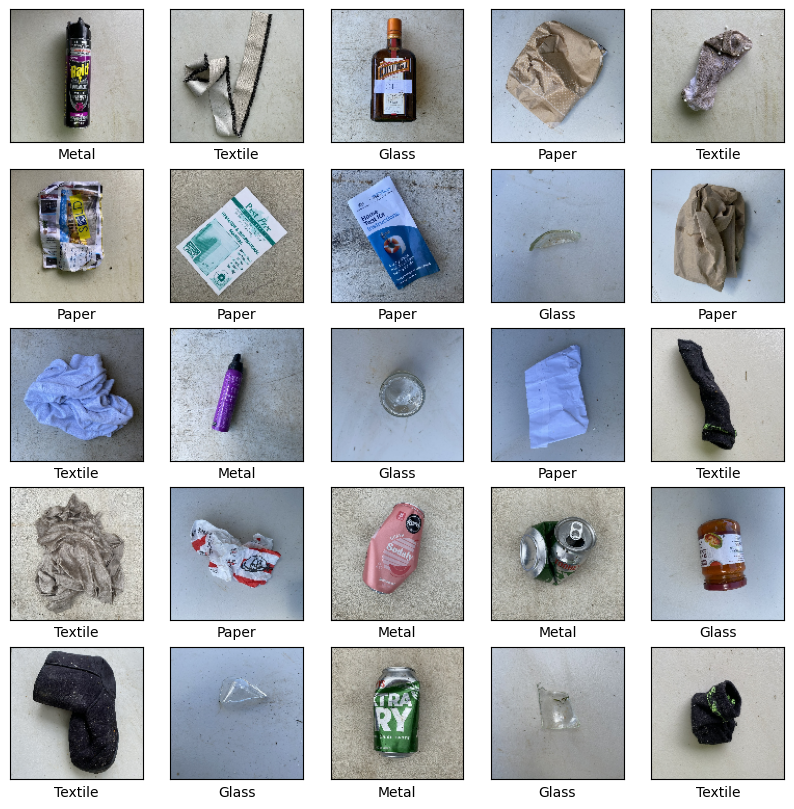

In [10]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [11]:
#Sequential Model 1
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((128, 128 ,3)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,872,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,892,548 (30.11 MB)

 Trainable params: 7,892,548 (30.11 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#Sequential Model 2 with image size 128, 128, 3
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((128,128,3)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 691,972 (2.64 MB)

 Trainable params: 691,972 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Sequential Model 3 
# Build a deep model 
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((128,128,3)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 284,452 (1.09 MB)

 Trainable params: 284,452 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [15]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [16]:
# Set number of epochs
epochs = 100
batch_size = 64



In [17]:
#Model 1 training
# Get the current time
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                       batch_size=batch_size, epochs=epochs,
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback1])

# Get the current time
end_time = datetime.now()
print('Time model end:', end_time) 
print('Model_1_training_time', end_time - start_time )

Time model start: 2024-11-07 13:04:11.165636
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.2659 - loss: 4.9194
Epoch 1: val_accuracy improved from -inf to 0.23611, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 539ms/step - accuracy: 0.2663 - loss: 4.8074 - val_accuracy: 0.2361 - val_loss: 1.3824
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.3067 - loss: 1.3688
Epoch 2: val_accuracy improved from 0.23611 to 0.28241, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 488ms/step - accuracy: 0.3067 - loss: 1.3679 - val_accuracy: 0.2824 - val_loss: 1.3762
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.3470 - loss: 1.2930
Epoch 3: val_accuracy improved from 0.28241 to 0.43056, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 476ms/step - accuracy: 0.3474 - loss: 1.2932 - val_accuracy: 0.4306 - val_loss: 1.2658
Epoch 4/100
14/14 ━

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - accuracy: 0.8535 - loss: 0.3406 - val_accuracy: 0.6620 - val_loss: 0.9244
Epoch 24/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8675 - loss: 0.3535
Epoch 24: val_accuracy did not improve from 0.76389
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.8693 - loss: 0.3498 - val_accuracy: 0.6991 - val_loss: 0.8406
Epoch 25/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9243 - loss: 0.2243
Epoch 25: val_accuracy did not improve from 0.76389
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - accuracy: 0.9239 - loss: 0.2242 - val_accuracy: 0.7500 - val_loss: 0.7465
Epoch 26/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9489 - loss: 0.2069
Epoch 26: val_accuracy did not improve from 0.76389
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.9483 - loss: 0.2062 - val_accuracy: 0.7454 - val_loss: 0.7961
Epoch 27/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9539 - loss: 0.1612
Epoch 27: val_accuracy d

Epoch 49/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9788 - loss: 0.0588
Epoch 49: val_accuracy did not improve from 0.76389
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step - accuracy: 0.9790 - loss: 0.0585 - val_accuracy: 0.7361 - val_loss: 1.1360
Epoch 50/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9921 - loss: 0.0321
Epoch 50: val_accuracy did not improve from 0.76389
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - accuracy: 0.9919 - loss: 0.0322 - val_accuracy: 0.7593 - val_loss: 1.1645
Epoch 51/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9790 - loss: 0.0586
Epoch 51: val_accuracy did not improve from 0.76389
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 436ms/step - accuracy: 0.9793 - loss: 0.0580 - val_accuracy: 0.7639 - val_loss: 1.1544
Epoch 52/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9859 - loss: 0.0422
Epoch 52: val_accuracy did not improve from 0.76389
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - accuracy: 0.9863 - loss: 0.0418 - val_accuracy

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9839 - loss: 0.0301
Epoch 74: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - accuracy: 0.9845 - loss: 0.0298 - val_accuracy: 0.7361 - val_loss: 1.5667
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9855 - loss: 0.0428
Epoch 75: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step - accuracy: 0.9856 - loss: 0.0429 - val_accuracy: 0.7454 - val_loss: 1.4490
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9879 - loss: 0.0389
Epoch 76: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 478ms/step - accuracy: 0.9878 - loss: 0.0386 - val_accuracy: 0.7500 - val_loss: 1.4435
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9888 - loss: 0.0277
Epoch 77: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step - accuracy: 0.9888 - loss: 0.0280 - val_accuracy: 0.7361 - va

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9891 - loss: 0.0277
Epoch 99: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 470ms/step - accuracy: 0.9892 - loss: 0.0276 - val_accuracy: 0.7315 - val_loss: 1.6325
Epoch 100/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9966 - loss: 0.0149
Epoch 100: val_accuracy did not improve from 0.76852
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 479ms/step - accuracy: 0.9965 - loss: 0.0150 - val_accuracy: 0.6713 - val_loss: 1.9868
Time model end: 2024-11-07 13:15:07.036044
Model_1_training_time 0:10:55.870408


In [18]:
# Model 2 training
# Get the current time
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback2])

# Get the current time
end_time = datetime.now()
print('Time model end:', end_time) 
print('Model_2_training_time', end_time - start_time )

Time model start: 2024-11-07 13:15:07.045664
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.2356 - loss: 1.6184
Epoch 1: val_accuracy improved from -inf to 0.23611, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 593ms/step - accuracy: 0.2357 - loss: 1.6101 - val_accuracy: 0.2361 - val_loss: 1.3847
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.2480 - loss: 1.3870
Epoch 2: val_accuracy did not improve from 0.23611
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 559ms/step - accuracy: 0.2492 - loss: 1.3869 - val_accuracy: 0.2361 - val_loss: 1.3820
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.2678 - loss: 1.3806
Epoch 3: val_accuracy improved from 0.23611 to 0.42593, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 559ms/step - accuracy: 0.2696 - loss: 1.3801 - val_accuracy: 0.4259 - val_loss: 1.3670
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.3420 - lo

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.8728 - loss: 0.3392
Epoch 24: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 637ms/step - accuracy: 0.8717 - loss: 0.3415 - val_accuracy: 0.7685 - val_loss: 0.5365
Epoch 25/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8594 - loss: 0.3621
Epoch 25: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 623ms/step - accuracy: 0.8593 - loss: 0.3624 - val_accuracy: 0.7731 - val_loss: 0.5982
Epoch 26/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9003 - loss: 0.3170
Epoch 26: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 559ms/step - accuracy: 0.8999 - loss: 0.3170 - val_accuracy: 0.7454 - val_loss: 0.6516
Epoch 27/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8920 - loss: 0.2967
Epoch 27: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 637ms/step - accuracy: 0.8914 - loss: 0.2983 - val_accuracy: 0.7778 - va

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9559 - loss: 0.1316
Epoch 49: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step - accuracy: 0.9559 - loss: 0.1317 - val_accuracy: 0.7685 - val_loss: 0.8751
Epoch 50/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9447 - loss: 0.1549
Epoch 50: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 575ms/step - accuracy: 0.9456 - loss: 0.1519 - val_accuracy: 0.7593 - val_loss: 0.8971
Epoch 51/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9680 - loss: 0.1029
Epoch 51: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 581ms/step - accuracy: 0.9685 - loss: 0.1015 - val_accuracy: 0.7824 - val_loss: 0.8898
Epoch 52/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9769 - loss: 0.0767
Epoch 52: val_accuracy improved from 0.82407 to 0.82870, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 573ms/step - a

Epoch 74/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9652 - loss: 0.0775
Epoch 74: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 546ms/step - accuracy: 0.9653 - loss: 0.0783 - val_accuracy: 0.7870 - val_loss: 0.7994
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9692 - loss: 0.0765
Epoch 75: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - accuracy: 0.9700 - loss: 0.0757 - val_accuracy: 0.8056 - val_loss: 0.7144
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9848 - loss: 0.0454
Epoch 76: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 595ms/step - accuracy: 0.9847 - loss: 0.0460 - val_accuracy: 0.7824 - val_loss: 0.8555
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9847 - loss: 0.0440
Epoch 77: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step - accuracy: 0.9850 - loss: 0.0439 - val_accuracy

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9904 - loss: 0.0274
Epoch 99: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 630ms/step - accuracy: 0.9904 - loss: 0.0275 - val_accuracy: 0.8056 - val_loss: 0.8279
Epoch 100/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9840 - loss: 0.0675
Epoch 100: val_accuracy did not improve from 0.83796
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 615ms/step - accuracy: 0.9839 - loss: 0.0671 - val_accuracy: 0.8241 - val_loss: 0.9008
Time model end: 2024-11-07 13:28:57.570331
Model_2_training_time 0:13:50.524667


In [19]:
#Model 3 training
# Get the current time
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback3])

# Get the current time
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-07 13:28:57.580082
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.2463 - loss: 1.4066
Epoch 1: val_accuracy improved from -inf to 0.35185, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 916ms/step - accuracy: 0.2470 - loss: 1.4060 - val_accuracy: 0.3519 - val_loss: 1.3836
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.2734 - loss: 1.3857
Epoch 2: val_accuracy did not improve from 0.35185
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 818ms/step - accuracy: 0.2739 - loss: 1.3857 - val_accuracy: 0.2870 - val_loss: 1.3827
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.3639 - loss: 1.3673
Epoch 3: val_accuracy improved from 0.35185 to 0.42130, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 912ms/step - accuracy: 0.3639 - loss: 1.3671 - val_accuracy: 0.4213 - val_loss: 1.3516
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.4195 - 

Epoch 24/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.8119 - loss: 0.5662
Epoch 24: val_accuracy improved from 0.70833 to 0.71296, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 923ms/step - accuracy: 0.8110 - loss: 0.5644 - val_accuracy: 0.7130 - val_loss: 0.6472
Epoch 25/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.7663 - loss: 0.5419
Epoch 25: val_accuracy did not improve from 0.71296
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 849ms/step - accuracy: 0.7675 - loss: 0.5413 - val_accuracy: 0.7130 - val_loss: 0.6430
Epoch 26/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.8182 - loss: 0.4812
Epoch 26: val_accuracy improved from 0.71296 to 0.71759, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 836ms/step - accuracy: 0.8166 - loss: 0.4841 - val_accuracy: 0.7176 - val_loss: 0.6363
Epoch 27/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.8071 - loss: 0.4981
Epoch 27: val_accuracy

Epoch 48/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.9471 - loss: 0.1937
Epoch 48: val_accuracy did not improve from 0.82870
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 771ms/step - accuracy: 0.9470 - loss: 0.1924 - val_accuracy: 0.7500 - val_loss: 0.6185
Epoch 49/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9607 - loss: 0.1081
Epoch 49: val_accuracy did not improve from 0.82870
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 799ms/step - accuracy: 0.9609 - loss: 0.1081 - val_accuracy: 0.8241 - val_loss: 0.5474
Epoch 50/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.9574 - loss: 0.1275
Epoch 50: val_accuracy did not improve from 0.82870
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 774ms/step - accuracy: 0.9567 - loss: 0.1286 - val_accuracy: 0.8009 - val_loss: 0.6289
Epoch 51/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.9464 - loss: 0.1510
Epoch 51: val_accuracy did not improve from 0.82870
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 772ms/step - accuracy: 0.9456 - loss: 0.1513 - val_accu

Epoch 73/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9583 - loss: 0.0933
Epoch 73: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 794ms/step - accuracy: 0.9588 - loss: 0.0921 - val_accuracy: 0.8241 - val_loss: 0.7270
Epoch 74/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9450 - loss: 0.1543
Epoch 74: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 806ms/step - accuracy: 0.9453 - loss: 0.1524 - val_accuracy: 0.8287 - val_loss: 0.5322
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9737 - loss: 0.0760
Epoch 75: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 776ms/step - accuracy: 0.9730 - loss: 0.0766 - val_accuracy: 0.8148 - val_loss: 0.5438
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9669 - loss: 0.0909
Epoch 76: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 775ms/step - accuracy: 0.9672 - loss: 0.0907 - val_accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9920 - loss: 0.0215
Epoch 98: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 823ms/step - accuracy: 0.9918 - loss: 0.0219 - val_accuracy: 0.8056 - val_loss: 0.7828
Epoch 99/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.9862 - loss: 0.0360
Epoch 99: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 819ms/step - accuracy: 0.9864 - loss: 0.0357 - val_accuracy: 0.8056 - val_loss: 0.6987
Epoch 100/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.9862 - loss: 0.0398
Epoch 100: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 819ms/step - accuracy: 0.9860 - loss: 0.0404 - val_accuracy: 0.8056 - val_loss: 0.6742
Time model end: 2024-11-07 13:48:20.059250
Model_3_training_time 0:19:22.479168


Text(0.5, 1.0, 'Model_1 Accuracy (Exp:1.6)')

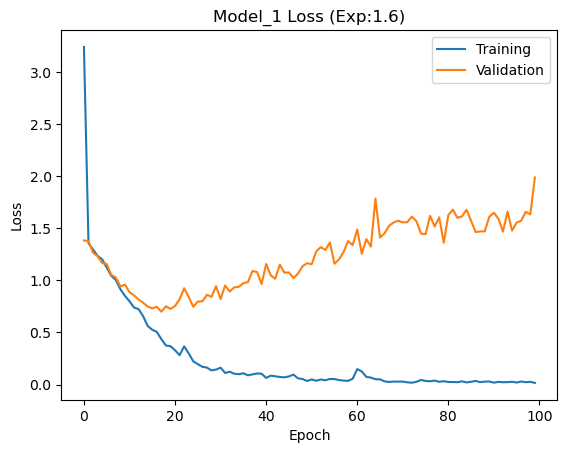

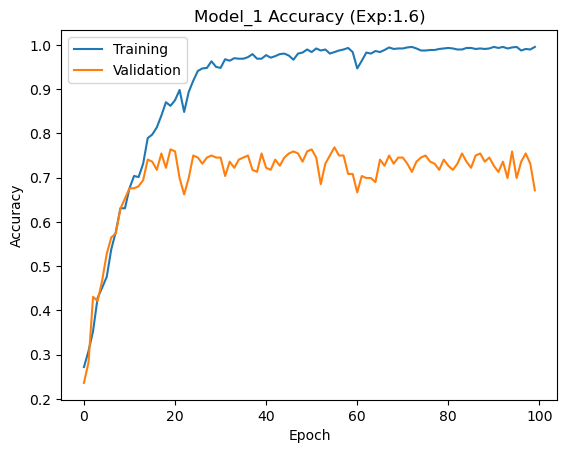

In [20]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model_1 Loss (Exp:1.6)')

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model_1 Accuracy (Exp:1.6)')


Text(0.5, 1.0, 'Model_2 Accuracy (Exp:1.6)')

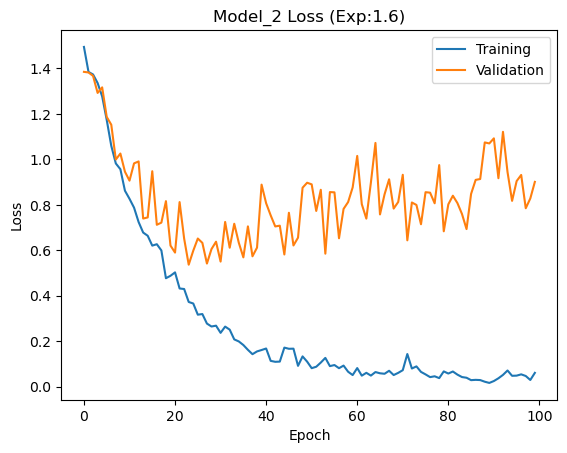

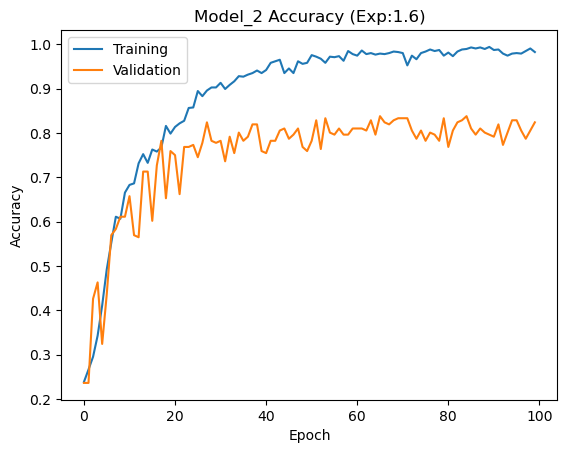

In [21]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model_2 Loss (Exp:1.6)')

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model_2 Accuracy (Exp:1.6)')

Text(0.5, 1.0, 'Model_3 Accuracy (Exp:1.6)')

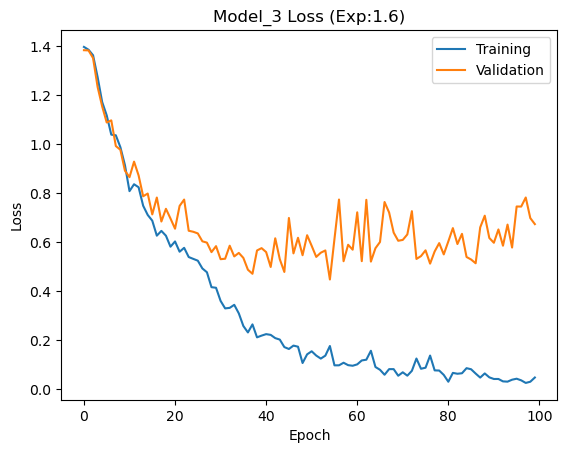

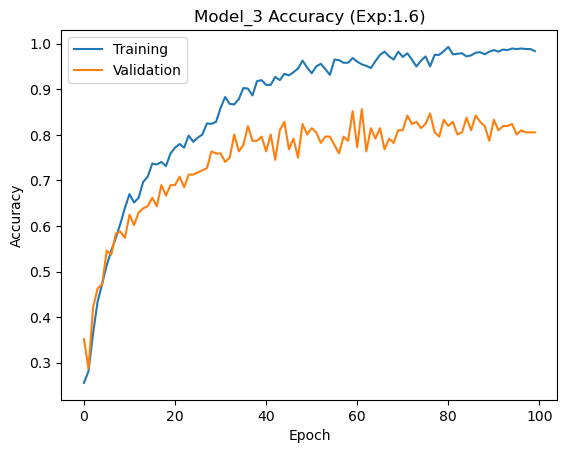

In [22]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model_3 Loss (Exp:1.6)')

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model_3 Accuracy (Exp:1.6)')

In [23]:
# Evaluate the test result for model 1, 2, 3
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6571 - loss: 1.7609 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8227 - loss: 1.0471
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8384 - loss: 0.9994


In [24]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [25]:
predictions2 = model_2.predict(test_images)     # Vector of probabilities
pred_label2 = np.argmax(predictions2, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [26]:
predictions3 = model_3.predict(test_images)     # Vector of probabilities
pred_label3 = np.argmax(predictions3, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


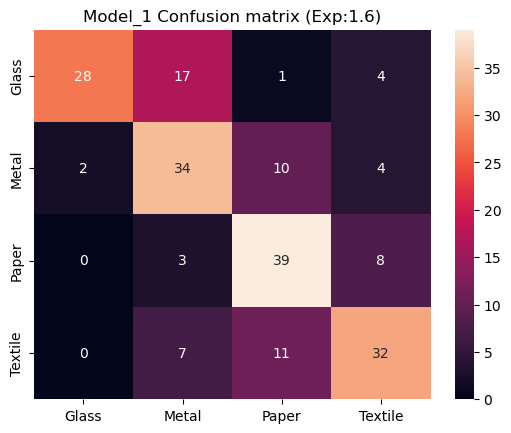

In [27]:
CM = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_1 Confusion matrix (Exp:1.6)')
plt.show()

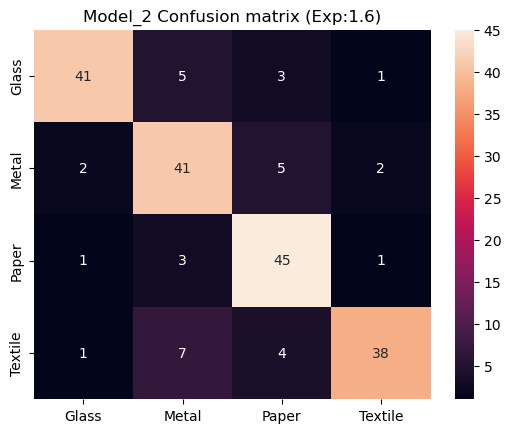

In [28]:
CM = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_2 Confusion matrix (Exp:1.6)')
plt.show()


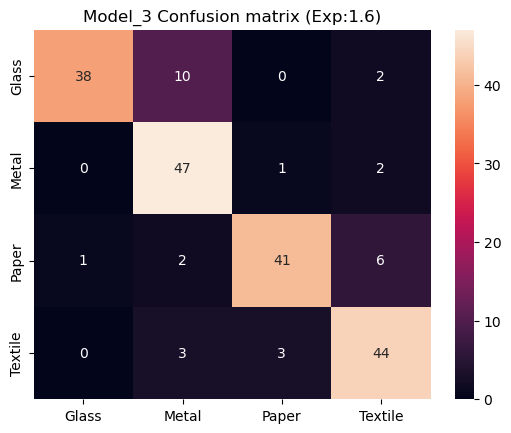

In [29]:
CM = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_3 Confusion matrix (Exp:1.6)')
plt.show()
